In [66]:
# Thêm autoreload vào để tự động reload lại module nếu có thay đổi code trong module
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler

# Các model scikit learn cho bài toán phân loại
from sklearn.svm import SVC # Support vector machine
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBClassifier
from tqdm import tqdm

import os, sys
sys.path.append(os.path.abspath(".."))

seed = 42
np.random.seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
from tqdm import tqdm
from sklearn.base import clone
from sklearn.utils.validation import check_is_fitted

class ProgressWrapper:
    """
    Lớp bao bọc để thêm thanh tiến trình `tqdm` cho quá trình huấn luyện của bất kỳ mô hình nào từ Scikit-learn.
    """
    def __init__(self, model):
        self.model = clone(model)

    def fit(self, X, y, **fit_params):
        # Đếm tổng số cây (estimators) được xây dựng trong RandomForestClassifier
        n_estimators = getattr(self.model, 'n_estimators', 1)

        with tqdm(total=n_estimators, desc="Training", unit="tree") as pbar:
            original_fit = self.model.fit

            def fit_and_update(*args, **kwargs):
                for i in range(n_estimators):
                    original_fit(*args, **kwargs)
                    pbar.update(1)

            self.model.fit = fit_and_update
            try:
                self.model.fit(X, y, **fit_params)
            finally:
                self.model.fit = original_fit
                pbar.close()

        return self

    def predict(self, X):
        check_is_fitted(self.model)
        return self.model.predict(X)

    def predict_proba(self, X : np.ndarray):
        check_is_fitted(self.model)
        return self.model.predict_proba(X)

    def score(self, X, y):
        check_is_fitted(self.model)
        return self.model.score(X, y)

    def __getattr__(self, name):
        return getattr(self.model, name)

In [68]:
train_df = pd.read_csv("../../data/key_points_rotate_scale_feature.csv")

In [69]:
train_df.head()

,label,nose_x,nose_y,nose_z,left_eye_inner_x,left_eye_inner_y,left_eye_inner_z,left_eye_x,left_eye_y,left_eye_z,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,1_lie_on,0.363741,-0.388996,-0.262433,0.364106,-0.420352,-0.241004,0.374649,-0.421859,-0.240937,...,-0.056336,0.228284,0.521316,-0.073264,0.263332,0.625602,-0.166788,0.202510,0.673799,-0.190334
1,1_lie_on,0.015858,-0.378837,-0.340744,0.041209,-0.407850,-0.317016,0.055542,-0.404492,-0.316981,...,0.079769,-0.039155,0.492840,0.049899,0.061888,0.528006,-0.046716,-0.091603,0.578926,-0.097076
2,1_lie_on,-0.004898,-0.287817,-0.618891,0.030431,-0.330377,-0.598566,0.052326,-0.331457,-0.598480,...,0.363640,0.046131,0.719894,0.161039,0.171082,0.583529,0.287587,0.057439,0.850740,0.005253
3,1_lie_on,-0.001934,-0.242759,-0.151025,-0.004938,-0.274365,-0.116603,0.005238,-0.275603,-0.116664,...,-0.185648,-0.136840,0.623762,-0.233900,-0.108481,0.687589,-0.285776,-0.134851,0.670538,-0.380920
4,1_lie_on,-0.023580,-0.221825,-0.204487,0.007783,-0.221798,-0.167069,0.027378,-0.211594,-0.166802,...,-0.016234,0.001532,0.539938,-0.098527,0.181119,0.601219,-0.119508,-0.001547,0.648505,-0.203064


In [70]:
# Chuyển dữ liệu của label về dạng số
from sklearn.preprocessing import LabelEncoder

# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["label"])

In [71]:
train_df["label"].value_counts()

label
0    154
1    150
2    134
Name: count, dtype: int64

In [72]:
X = train_df.drop(columns = ['label'])
y = train_df['label']

In [73]:
feature_groups = []

for i in range(0, 99, 3):
    feature_groups.append([X.columns[i], X.columns[i+1], X.columns[i+2]])

In [74]:
class GroupedRFE:
    def __init__(self, estimator : RandomForestClassifier, n_groups_to_select):
        self.estimator = estimator
        self.n_groups_to_select = n_groups_to_select
        self.support_ = None

    def fit(self, X, y):
        n_groups = len(feature_groups)
        group_support_ = np.ones(n_groups, dtype=bool)

        while np.sum(group_support_) > self.n_groups_to_select:
            # Lấy các cột hiện tại tương ứng với các nhóm feature còn được chọn
            current_features = np.hstack([feature_groups[i] for i in range(n_groups) if group_support_[i]])
            X_subset = X[current_features]

            # Huấn luyện mô hình
            self.estimator.fit(X_subset, y)

            # Kiểm tra độ dài của feature_importances_
            if len(self.estimator.feature_importances_) != X_subset.shape[1]:
                raise ValueError("Số lượng feature_importances không khớp với số feature hiện tại")

            # Tính toán độ quan trọng của từng nhóm
            group_importances = []
            for i, group in enumerate(feature_groups):
                if group_support_[i]:
                    # Kiểm tra xem group có tồn tại trong X hay không
                    X_group = X[group]
                    importances = self.estimator.feature_importances_[:len(group)]  # Lấy các giá trị quan trọng
                    group_importances.append(np.mean(importances))
                else:
                    group_importances.append(np.inf)  # Không xét nhóm đã bị loại

            # Loại bỏ nhóm ít quan trọng nhất
            group_support_[np.argmin(group_importances)] = False

        # Lưu lại các nhóm được chọn
        self.support_ = group_support_

    def transform(self, X):
        # Chỉ giữ lại các nhóm feature đã được chọn
        selected_features = np.hstack([feature_groups[i] for i in range(len(feature_groups)) if self.support_[i]])
        return X[selected_features]


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
results = []

model_best = RandomForestClassifier(n_estimators=100)

for i in range(1, 34):
    grouped_rfe = GroupedRFE(model_best, i)
    grouped_rfe.fit(X_train, y_train)

    # Kiểm tra các nhóm feature được chọn
    selected_groups = [group for group, support in zip(feature_groups, grouped_rfe.support_) if support]

    # Biến đổi dữ liệu để chỉ giữ các feature đã chọn
    X_selected_train = grouped_rfe.transform(X_train)
    X_selected_test = grouped_rfe.transform(X_test)

    # Huấn luyện mô hình với các feature đã được chọn
    model_best.fit(X_selected_train, y_train)

    # Dự đoán trên tập test
    y_pred = model_best.predict(X_selected_test)

    # Tính độ chính xác
    accuracy = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy with {i} keypoints: {accuracy}")

    results.append({
        "n_features": i,
        "accuracy": accuracy,
        "selected_keypoints": selected_groups
    })

Accuracy with 1 keypoints: 0.6959902597402597
Accuracy with 2 keypoints: 0.7664281928987812
Accuracy with 3 keypoints: 0.7476563557367495
Accuracy with 4 keypoints: 0.7646112132413502
Accuracy with 5 keypoints: 0.7965211402563181
Accuracy with 6 keypoints: 0.7809360450869884
Accuracy with 7 keypoints: 0.8254317593246561
Accuracy with 8 keypoints: 0.8554557375312093
Accuracy with 9 keypoints: 0.8538938795065277
Accuracy with 10 keypoints: 0.8755855658029571
Accuracy with 11 keypoints: 0.8766878946023868
Accuracy with 12 keypoints: 0.8869492021665935
Accuracy with 13 keypoints: 0.876393438893439
Accuracy with 14 keypoints: 0.8868006993006993
Accuracy with 15 keypoints: 0.8564228881513329
Accuracy with 16 keypoints: 0.8564228881513329
Accuracy with 17 keypoints: 0.8564228881513329
Accuracy with 18 keypoints: 0.8653297682709448
Accuracy with 19 keypoints: 0.8462509712509712
Accuracy with 20 keypoints: 0.8360297356111865
Accuracy with 21 keypoints: 0.8868006993006993
Accuracy with 22 keypoi

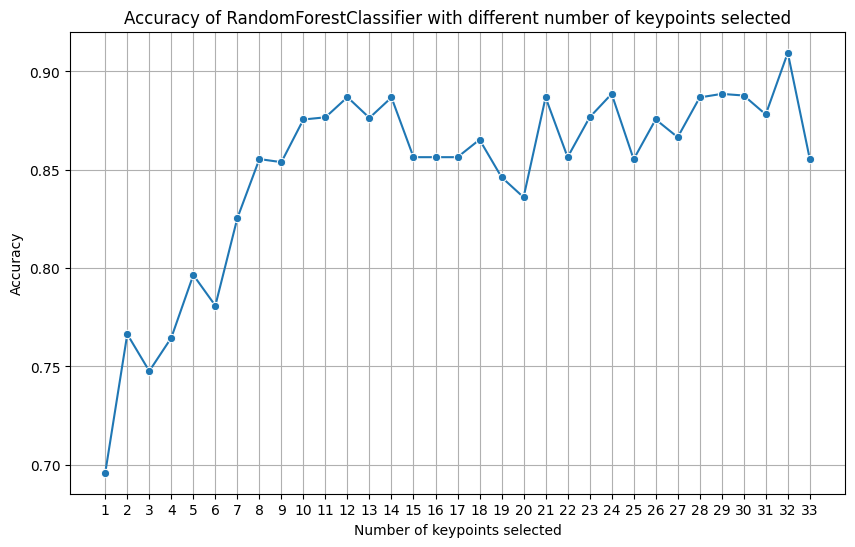

In [82]:
results_df = pd.DataFrame(results)
results_df.head()

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x="n_features", y="accuracy", marker="o")
plt.xticks(range(1, 34))
plt.xlabel("Number of keypoints selected")
plt.ylabel("Accuracy")
plt.title("Accuracy of RandomForestClassifier with different number of keypoints selected")
plt.grid(True)
plt.show()

In [78]:
n_features_best = 16

In [79]:
print("Best number of feature groups:", results_df.loc[n_features_best - 1]["accuracy"])

Best number of feature groups: 0.8564228881513329


In [80]:
selected_keypoints_best = results_df.loc[n_features_best - 1]["selected_keypoints"]

In [81]:
print("Best selected keypoints:")
for group in selected_keypoints_best:
    print(group)

Best selected keypoints:
['left_pinky_x', 'left_pinky_y', 'left_pinky_z']
['right_pinky_x', 'right_pinky_y', 'right_pinky_z']
['left_index_x', 'left_index_y', 'left_index_z']
['right_index_x', 'right_index_y', 'right_index_z']
['left_thumb_x', 'left_thumb_y', 'left_thumb_z']
['right_thumb_x', 'right_thumb_y', 'right_thumb_z']
['left_hip_x', 'left_hip_y', 'left_hip_z']
['right_hip_x', 'right_hip_y', 'right_hip_z']
['left_knee_x', 'left_knee_y', 'left_knee_z']
['right_knee_x', 'right_knee_y', 'right_knee_z']
['left_ankle_x', 'left_ankle_y', 'left_ankle_z']
['right_ankle_x', 'right_ankle_y', 'right_ankle_z']
['left_heel_x', 'left_heel_y', 'left_heel_z']
['right_heel_x', 'right_heel_y', 'right_heel_z']
['left_foot_index_x', 'left_foot_index_y', 'left_foot_index_z']
['right_foot_index_x', 'right_foot_index_y', 'right_foot_index_z']
